# Learning to Learn with Quantum NN via Classical NN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/stfnmangini/QOSF-Mentorship/blob/main/l2l_1.ipynb)

The aim of this notebook is to recreate the architecture proposed by Verdon et al. in the paper *Learning to learn with quantum neural networks via classical neural networks* [[1]](#1), using **PennyLane** [[2]](#2) and **Tensorflow** [[3]](#3).  

We will start with a brief theoretical overview explaining the problem and the setup used to solve it. After that, we will deep dive into the code to build a fully functioning model, ready to be further developed or customized to your own needs. Without further ado, let's start!

---

### Problem: *Optimization of Variational Quantum Algorithms (VQAs)*

Recently, a big effort by the quantum computing community has been devoted towards the study of variational quantum algorithms (VQAs, for short) which leverage quantum circuits with fixed shape but with tunable parameters to solve a desired target task. The idea is similar to classical neural networks, where the weights of the net are optimized during training in order to perform best in regression or classification tasks. Similarly, once the shape of variational quantum circuit is chosen — something that is very difficult and sensitive to the particular task at hand — its tunable parameters are optimized iteratively by minimizing a cost (or loss) function, which measures how good the quantum algorithm is performing (see [[4]](#4) for a thorough overview on VQAs). 


A major challange for VQAs relates to the optimization of tunable parameters, which was shown to be a very hard task to perform (see *barren plateus*). In particular, parameter initialization plays a key role in this scenario, since initializing the parameters in the proximity of an optimal solution leads to faster convergence and better results with respect to random initialization, which could bring the model in a region in parameter space far from any good solution. Thus, a good initialization strategy is crucial to promote the convergence of local optimizers to local extrema and to select reasonably good local minima.  

One such strategy, could come from the classical machine learning literature. 


### Solution: *(Classical) Recurrent Neural Networks* 

By building up on results from *meta learning* literature in Classical ML, authors in [[1]](#1) propose to use a Recurrent Neural Network (RNN) as a black-box controller to optimize the tunable parameters of variational quantum algorithms, as shown in the figure below. The cost function used for the variational quantum circuits consists of the expectation value $\langle H\rangle_{\boldsymbol{\theta}} = \langle \psi_{\boldsymbol{\theta}}| H|\psi_{\boldsymbol{\theta}}\rangle $ of an hamiltonian $H$ evaluated on the parametrized state $\psi_{\boldsymbol{\theta}}$ created by the variaitonal quantum circuit.

|  |
|:--|
| |
| <img src="image.jpg" alt="Scheme of the proposed architecture, taken from [[1]](#1)" width="600"/> | 
| **Recurrent Neural Network Scheme**. Given the variational parameters of the quantum circuit $\boldsymbol{\theta}_{t-1}$, the cost function $y_{t-1}$, and the hidden state of the classical network $m_{t-1}$ at the previous time step, the CPU (classical computer) proposes a new guess for the parameters $\boldsymbol{\theta}_t$, which are then fed into the QPU (quantum computer) to evaluate the cost function $y_t$. By repeating this cycle few times, and by training the recurrent neural network's weights in order to minimize the loss function $y_t$, a good initialization heuristic for the quantum variational parameters $\boldsymbol{\theta}$ is found. The cost function taken into account here is given by the expectation value $\langle H\rangle_{\boldsymbol{\theta}}$, of an Hamiltonian $H$ on the quantum state $|\psi_\theta\rangle$ parametrized by angles $\boldsymbol{\theta}$. This image is taken directly from the paper [[1]](#1).|

At a given iteration, the RNN receives as input the previous cost function $y_t$ evaluated on the quantum computer, where $y_t$ is the estimate of $\langle H\rangle_{t}$, as well as the parameters for which the variational circuit was evaluated $\boldsymbol{\theta}_t$. The RNN at this time step also receives information stored in its internal hidden state from the previous time step $m_t$. The RNN itself has trainable parameters $\phi$, and hence it applies the parameterized mapping:  

$$ m_{t+1}, \boldsymbol{\theta}_{t+1} = \text{RNN}_{\phi}(m_{t}, \boldsymbol{\theta}_{t}, y_{t}) $$

which generates a new suggestions for the variational parameters as well as a new internal state. Upon training the weights $\phi$, the RNN eventually learns a good heuristic to suggest optimal parameters for the quantum circuit.  


### Before starting: QAOA and MaxCut
There are multiple VQAs for which this hybrid training routine could be used, some of them directly analyzed in [[1]](#1). In the following, we will only focus on one of such examples, that is the use of the QAOA (Quantum Approximate Optimization Algorithm) for solving the MaxCut problem for graphs. Thus, referring to the picture above, the shape of the variational circuit is the one dictated by the QAOA ansatze, and this quantum circuit is be used to evaluate the cost hamiltonian $H$ of the MaxCut problem of some graphs.  
If you wish to refresh your memories about such topics, have a look at this great tutorial: https://pennylane.ai/qml/demos/tutorial_qaoa_maxcut.html

---

#### References
<a id="1">[1]</a> 
Verdon G., Broughton M., McClean J. R., Sung K. J., Babbush R., Jiang Z., Neven H. and Mohseni M. (2019),  
Learning to learn with quantum neural networks via classical neural networks, [arXiv:1907.05415](https://arxiv.org/abs/1907.05415).

<a id="2">[2]</a> 
https://pennylane.ai/

<a id="3">[3]</a> 
https://www.tensorflow.org/

<a id="4">[4]</a> 
Cerezo M., Arrasmith A., Babbush R., Benjamin S. C., Endo S., Fujii K., McClean J. R., Mitarai K., Yuan X., Cincio L. and Coles P. J. (2020),  
Variational Quantum Algorithms, [arXiv:2012.09265](https://arxiv.org/abs/2012.09265).  

---


**Run cell below only if using this notebook in Colab**  
If you're running this notebook on Colab, you need to install the following dependencies. On the other hand, if you're running this on your personal computer, be sure to have Tensorflow, Pennylane and Networkx installed

In [ ]:
IS_COLAB = False
if IS_COLAB:
    # Tensorflow is installed by default on Colab 
    !pip install --upgrade pennylane
    !pip install networkx

#### Importation of required packages

As already mentioned at the start of the notebook, we will use *Pennylane* for the quantum circuits execution and for its seamless integration with *Tensorflow*, which will be used for creating the RNN. 

In [1]:
# Quantum Machine Learning
import pennylane as qml
from pennylane import qaoa

# Classical Machine Learning
import tensorflow as tf

# Generation of graphs
import networkx as nx

import numpy as np
import matplotlib.pyplot as plt

# Set the seed for reproducibility of results
np.random.seed(42)
tf.random.set_seed(42)

---

### Generation of training data: Graphs

As for any Machine Learning project, the first step is to gather (or in our case create) a good dataset, which will be used to train the model and test its performances. In our case, we are analyzing the MaxCut problem, with deals with the problem of finding a good binary partition of nodes in a *graph*, such that the number of edges *cut* by such separation is maximized. For this reason, we start by generating some random graphs $G_{n,p}$ where:
- $n$ is the number of nodes in the graphs
- $p$ is the probability of having an edge between two nodes

In [3]:
def generate_graphs(n_graphs, n_nodes, p_edge):
    """
    Generate a list containing random graphs generated by Networkx. 
    
    Args:
    n_graphs: length of final list, that is the number of graphs to generate.
    n_nodes: number of nodes in each graph.
    p_edge: probability of having an edge between two nodes. (See Networkx's documentation)
    
    Returns:
    datapoints: list containing the generated graphs
    """
    
    datapoints = []
    for _ in range(n_graphs):
        random_graph = nx.gnp_random_graph(n_nodes, p = p_edge)
        datapoints.append(random_graph)
    return datapoints

An example of random graph

Sample of a random graph with 7 nodes and 7 edges (p=0.43)


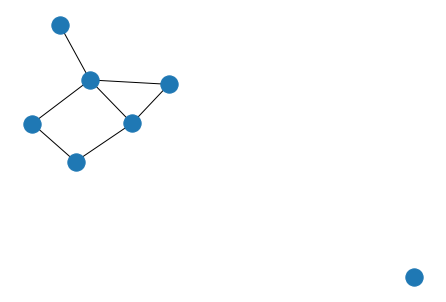

In [5]:
# Define parameters of the graphs
n_graphs = 100
n_nodes = 7
p_edge = 3./n_nodes
graphs = generate_graphs(n_graphs, n_nodes, p_edge)

print(f"Sample of a random graph with {len(graphs[0].nodes)} nodes and {len(graphs[0].edges)} edges (p={p_edge:.2f})")
nx.draw(graphs[0])

---

### Variational Quantum Circuit: QAOA  

Now that we have a dataset, we move on by creating the QAOA quantum circuits using Pennylane's builtin libraries. In particular, using Pennylane's `qaoa` module, we will able to create fully functioning quantum circuits with very few lines of code.

In [7]:
def qaoa_from_graph(graph, n_layers = 1):
    """
    Creates a QAOA instance of the MaxCut problem given a graph. This function uses nested functions needed
    for the creation of the quantum circuit. When called, it instantiate the QAOA circuit for the input graph 
    and outputs a function which, upon feeding of the parameters, evaluates the MaxCut cost function for the 
    given graph. 
    
    Args:
    ------
    graph: A graph generated with Networkx.
    n_layers: Number of repetitions in the QAOA ansatz.
    
    Returns:
    ------
    hamiltonian: A function which, given some parameters as input, evaluates the MaxCutcost function of the 
    QAOA quantum circuit for the specified graph.
    """
        
    # Number of qubits (wires) equal to the number of nodes in the graph
    wires = range(len(graph.nodes))
    
    # Define the structure of the cost and mixer subcircuits
    cost_h, mixer_h = qaoa.maxcut(graph)   
    
    # Defines a layer of the QAOA ansatz from the cost and mixer Hamiltonians
    def qaoa_layer(gamma, alpha):
        qaoa.cost_layer(gamma, cost_h)
        qaoa.mixer_layer(alpha, mixer_h)
       
    # Creates the actual quantum circuit for the QAOA algorithm
    def circuit(params, **kwargs): 
        for w in wires:
            qml.Hadamard(wires=w)
        qml.layer(qaoa_layer, n_layers, params[0], params[1])
     
    # Evaluates the cost function
    def hamiltonian(params, **kwargs):
        """
        Function that evaluates the actual MaxCut cost of the QAOA, given the angles for the circuit 
        and the specified graph. 
        
        Args:
        ------
        params: List of angles for the QAOA circuit, with shape (n_layers x 2). 
        params has the shape [angles_1, ..., angles_(n_layers)], where angles_i = [alphas_i, gammas_i].
        
        Returns:
        ------
        cost: Cost hamiltonian evaluated with the input angles.
        
        """
        # We set the default.qubit.tf device for seamless integration with Tensorflow
        dev = qml.device('default.qubit.tf', wires=len(graph.nodes))
        # ExpvalCost evaluates the Expectation value of an operator on a circuit
        cost = qml.ExpvalCost(circuit, cost_h, dev, interface="tf",  diff_method = "backprop")
        return cost(params)
    
    return hamiltonian

Before moving on, let's see how to use these functions

In [8]:
# Create an instance of a QAOA circuit given a graph.
cost = qaoa_from_graph(graph = graphs[0], n_layers = 1)

# Define some paramenters
# Since we use only one layer in QAOA, params have the shape 1 x 2, in the form [[alpha, gamma]]. 
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Evaluate th QAOA instance just created with some angles.
cost(x)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([-2.08162658])>

Now we optimize the parameters to reduce the cost function `cost`. We can do this using the `tf.GradientTape()`, which works directly thanks to Pennylane seamless integration with Tensorflow when using the `default.qubit.tf` device.

In [9]:
x = tf.Variable([[0.5], [0.5]], dtype = tf.float32)

# Select an optimizer
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Choose the number of optimization steps
step = 15

# Start of optimization (or training)
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = cost(x)
        
    gradients = tape.gradient(loss, [x])
    opt.apply_gradients(zip(gradients, [x]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"\nFinal cost function: {cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-2.08162658]
Step 1 - Loss = [-2.52991851]
Step 2 - Loss = [-3.05405209]
Step 3 - Loss = [-3.47125931]
Step 4 - Loss = [-3.64636716]
Step 5 - Loss = [-3.64914416]
Step 6 - Loss = [-3.67344869]
Step 7 - Loss = [-3.77857654]
Step 8 - Loss = [-3.92728955]
Step 9 - Loss = [-4.06789741]
Step 10 - Loss = [-4.17508691]
Step 11 - Loss = [-4.26409672]
Step 12 - Loss = [-4.36769486]
Step 13 - Loss = [-4.49882886]
Step 14 - Loss = [-4.63825216]
Final cost function: [-4.74817983]
Optimized angles: [[0.6159616]
 [1.2706409]]


As you can see, the Loss function is correctly minimized throughout the optimization process, which eventually yields an optimal value for the angles in the QAOA ansatze. 

---

### Recurrent Neural Network: LSTM  

So far, we have defined the machinery which let us build the QAOA algorithm for solving the MaxCut problem of a graph.  
Now we wish to implement the Recurrent Neural Network architecture explained previously. In particular, as proposed in the original paper, we will build a custom model of an LSTM (Long-Short Term Memory) network, capable of handling the hybrid data passing between classical and quantum procedures. For this task, we will use `Keras` and `Tensorflow`.  

First of all, let's define the elemental building block of the model, that is an LSTM cell (see [Tensorflow documentation](https://www.tensorflow.org/api_docs/python/tf/keras/layers/LSTMCell) for further details).

In [11]:
# Number of layers in QAOA ansatz. The higher the better in terms of performancec, 
# but it gets also more computationally hard. For simplicity, we will stick to the single layer case.
n_layers = 1

# Define a single LSTM cell. The cell has two units per layer
# since each layer in QAOA ansatze make use of two angles (parameters). 
cell = tf.keras.layers.LSTMCell(2*n_layers)

Using the `qaoa_from_graph` function, we create a list `graph_cost_list` containing the cost functions of a set of graphs. You can see this as a preprocessing step of the data.

In [13]:
# We create the QAOA MaxCut cost functions of some graphs
graph_cost_list = [qaoa_from_graph(g) for g in graphs[:20]]

At this stage, we seek to reproduce the recurrent behaviour depicted in the picture above, outlining the functioning of RNN as a black-box optimizer. We do so defining two functions:   
- `rnn_iteration`: accounts for the computations happening on a single time step in the figure, that is it performs the calculation inside the CPU and evaluates the quantum circuit on the QPU to obtain the loss function for the current parameters.
- `recurrent_loop`: as the name says, it accounts for the creation of the recurrent loop of the model. In particular, it makes consecutive calls to the `rnn_iteration` function, where the ouputs of a previous call are fed as inputs of the next call. 

In [17]:
def rnn_iteration(inputs, graph_cost, n_layers = 1):
    """
    This function performs a single time step in the computational graph. It takes as inputs the outputs from
    the previous time step and a graph cost function, and then goes through the Keras' LSTM cell whose output 
    is used to evaluated the QAOA MaxCut cost function. 
    
    Args:
    ------
    inputs: List of inputs coming from the previous timestep: cost function, parameters, first LSTM hidden state,
    second LSTM hidden state. 
    graph_cost: Cost function of a graph coming from the qaoa_from_graph function.
    
    Returns:
    ------
    List containing new value for the cost, parameters, and hidden states. 
    """
    # Unpack the inputs list containing previous cost, parameters, and hidden states (denoted as 'h' and 'c').
    prev_cost = inputs[0]
    prev_params = inputs[1]
    prev_h = inputs[2]
    prev_c = inputs[3]
    
    # Concatenate the previous parameters and previous cost to create new input
    new_input = tf.keras.layers.concatenate([prev_cost, prev_params])
        
    # Call to the LSTM cell, which outputs new values for the parameters along with new internal states h and c
    new_params, [new_h, new_c] = cell(new_input, states = [prev_h, prev_c])
             
    # Reshaping the parameters to correctly match those expected by Pennylane
    _params = tf.reshape(new_params, shape = (2, n_layers))
             
    # Evaluation of the cost using new angles 
    _cost = graph_cost(_params)
    
    # Reshaping to be consistent with other tensors
    new_cost = tf.reshape(tf.cast(_cost, dtype=tf.float32), shape = (1,1))
    
    return [new_cost, new_params, new_h, new_c] 

def recurrent_loop(graph_cost, n_layers = 1, intermediate_steps = False):
    """
    This function actually creates the recurrent architecure, connecting multiple consecutive iterations 
    of the custom LSTM model creted in `rnn_iteration`.
    
    Args:
    ------
    graph_cost: Cost function of a graph coming from the qaoa_from_graph function.
    intermediate_steps: Boolean flag, set to True if you wish to store values from intermediate iterations.

    Returns:
    ------
    loss: Loss function driving the minimization process. 
    """
    # Initialize starting all inputs (cost, parameters, hidden states) as zeros.
    initial_cost = tf.zeros(shape = (1, 1))
    initial_params = tf.zeros(shape = (1, 2*n_layers))
    initial_h = tf.zeros(shape = (1, 2*n_layers))
    initial_c = tf.zeros(shape = (1, 2*n_layers))
    
    # We perform five consecutive calls to 'rnn_iteration', thus creating the recurrent loop.
    # More iterations lead to better results, at the cost of a expensive computation.
    out0 = rnn_iteration([initial_cost, initial_params, initial_h, initial_c], graph_cost)
    out1 = rnn_iteration(out0, graph_cost)
    out2 = rnn_iteration(out1, graph_cost)
    out3 = rnn_iteration(out2, graph_cost)
    out4 = rnn_iteration(out3, graph_cost)
    
    # This cost function takes into account the cost from all iteration but using different weights. 
    loss = tf.keras.layers.average([0.1 * out0[0], 0.2 * out1[0], 0.3 * out2[0], 0.4 * out3[0], 0.5 * out4[0]])
    
    if intermediate_steps:
        return [out0[1], out1[1], out2[1], out3[1], loss]
    else:
        return loss

#### The cost function
A key part in the `recurrent_loop` function, is given by the definition of the variable `loss`. In order to drive the learning procedure of the weights in the LSTM cell, a cost function is needed. While in the original paper the authors suggest to use a measure called *observed improvement*, here we use a simpler cost function $\cal{L}(\phi)$ defined as:  

$$\cal{L}(\phi) = {\bf w} \cdot {\bf y}_t(\phi)$$

where ${\bf y}_t(\phi) = (y_1, \cdots, y_5)$ is the history hamiltonian cost function from all iterations, and ${\bf w}$ are just some coefficients. In this case we used ${\bf w}=(0.1, 0.2, 0.3, 0.4, 0.5)$, thus giving more importance to last steps.  
Note that while one could directly use even just the final cost function from the last iteration to drive the learning procedure of the RNN, using also values from intermediate steps allows for a smoother suggestion routine, since even non optimal parameter suggestions from early steps are penalized using $\cal{L}(\phi)$.

---

### Training

Now all the cards are on the table and we just need to prepare a training routine and then run it!

First of all, let's wrap a single gradient descent step inside a custom function `train_step`.

In [18]:
def train_step(graph_cost):
    """
    Single optimization step in the training procedure. Given the cost/circuit of a graph, it evaluates the
    corresponding loss and eventually computes the gradients and update of the prameters.
    
    Args:
    ------
    graph_cost: cost function of a graph coming from the qaoa_from_graph function.
    
    Returns:
    ------
    loss: loss for the specified graph, for current value of the parameters.
    """
    with tf.GradientTape() as tape:
        # Evaluates cost function
        loss = recurrent_loop(graph_cost)
    # Evaluates gradients. cell' is the LSTM cell defined previously
    grads = tape.gradient(loss, cell.trainable_weights)
    # Apply gradients and update the weights of the LSTM cell
    opt.apply_gradients(zip(grads, cell.trainable_weights))
    return loss

We are now ready for starting the training. In particular, we will perform a stochastic gradient descent in the parameter space of the weights of the LSTM cell. For each graph in the training set, we evaluate gradients and update the weights accordingly. Then, we repeat this procedure for multiple times (epochs).

> For a QAOA ansatze using one single layer, and for a training set of 20 graphs, each epoch takes approximately ~1m to run on a standard laptop. Be careful when using bigger dataset or training for larger epochs.

In [19]:
# Select an optimizer 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 5

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(graph_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i}/{len(graph_cost_list)} - Loss: {loss[0][0]}")
    print(f" >>  Mean Loss during epoch: {np.mean(total_loss)}")

Epoch 0
 > Graph 0/20 - Loss: -1.0958744287490845
 > Graph 5/20 - Loss: -1.9112132787704468
 > Graph 10/20 - Loss: -0.93351811170578
 > Graph 15/20 - Loss: -1.5009876489639282
------
 >  Mean Loss during epoch: -1.6746937304735183
Epoch 1
 > Graph 0/20 - Loss: -1.409367561340332
 > Graph 5/20 - Loss: -1.9812055826187134
 > Graph 10/20 - Loss: -0.9737359881401062
 > Graph 15/20 - Loss: -1.4768927097320557
------
 >  Mean Loss during epoch: -1.7434221237897873
Epoch 2
 > Graph 0/20 - Loss: -1.4190870523452759
 > Graph 5/20 - Loss: -2.012418031692505
 > Graph 10/20 - Loss: -0.9720567464828491
 > Graph 15/20 - Loss: -1.5021851062774658
------
 >  Mean Loss during epoch: -1.7623199701309205
Epoch 3
 > Graph 0/20 - Loss: -1.4325796365737915
 > Graph 5/20 - Loss: -2.020969867706299
 > Graph 10/20 - Loss: -0.980493426322937
 > Graph 15/20 - Loss: -1.4880000352859497
------
 >  Mean Loss during epoch: -1.767683321237564
Epoch 4
 > Graph 0/20 - Loss: -1.4357184171676636
 > Graph 5/20 - Loss: -2.

As you can see, the Loss for each graph keeps decreasing accross epochs, indicating that the training routine is working correctly.  

---

### Results

Let's see how to use the optimized RNN as an initializer for the angles in the QAOA algorithm. 

First, we pick a new graph, not present in the training set:

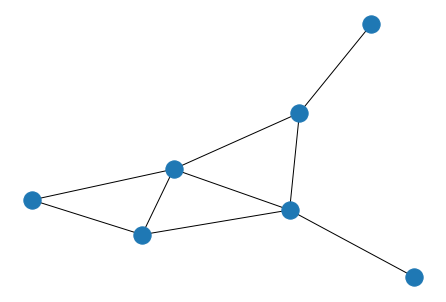

In [20]:
new_graph = nx.gnp_random_graph(7, p = 3/7)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

Then we apply the trained RNN to this new graphs, saving intermediate results coming from all the recurrent iterations in the network

In [22]:
# Apply the RNN (be sure that training was performed)
res = recurrent_loop(new_cost, intermediate_steps = True)

# Extract all angles suggestions
guess_0 = tf.zeros(shape = (2*n_layers, 1))
guess_1 = res[0]
guess_2 = res[1]
guess_3 = res[2]
guess_4 = res[3]
final_loss = res[4]

# Wrap them into a list
guesses = [guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape = (2, n_layers))) for guess in guesses]

We can plot these losses in a graph

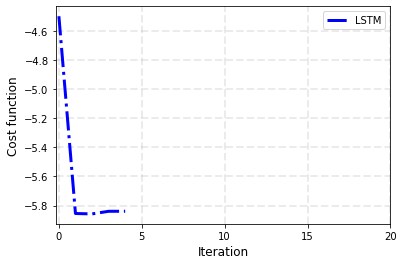

In [25]:
fig, ax = plt.subplots()

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
plt.legend()
ax.set_xticks([0,5,10,15,20]);

#### Comparison with standard Stochastic Gradient Descent (SGD)

It is instructive to compare such method with a standard optimization technique leveraging stochastic gradient descent to optimize the parameters in the QAOA. 

In [26]:
x0 = tf.Variable(np.random.rand(2,1))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x0)
        
    steps.append(x0)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x0])
    opt.apply_gradients(zip(gradients, [x0]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-4.56850703]
Step 1 - Loss = [-4.60551143]
Step 2 - Loss = [-4.64448065]
Step 3 - Loss = [-4.68810431]
Step 4 - Loss = [-4.73832621]
Step 5 - Loss = [-4.79641042]
Step 6 - Loss = [-4.86288697]
Step 7 - Loss = [-4.93743624]
Step 8 - Loss = [-5.01879549]
Step 9 - Loss = [-5.10478058]
Step 10 - Loss = [-5.19249333]
Step 11 - Loss = [-5.27871816]
Step 12 - Loss = [-5.36042254]
Step 13 - Loss = [-5.43521241]
Step 14 - Loss = [-5.5016049]
Final cost function: [-5.84209647]
Optimized angles: [[0.6159616]
 [1.2706409]]


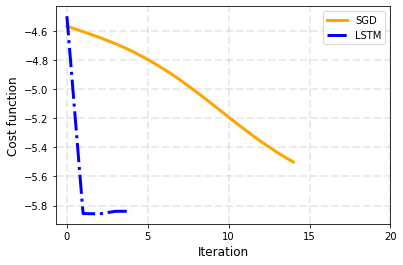

In [29]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color = "orange", lw = 3, label="SGD")

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.legend()
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
ax.set_xticks([0,5,10,15,20]);

Hurray! 🎉🎉   
As is it clear from the picture, that the RNN reaches a better minimum in much fewer iteration compared to standard SGD (Stochastic Gradient Descent). Thus, as the authors suggest, the RNN can be used for few iterations at the start of the training procedure to actually initialize the parameters of the quantum circuit arbitrarly close to a optimal solution. Then, a standard optimizator, like the SGD, can be used to fine tune the proposed parameters and reach even better solutions.

#### Loss landscape in parameter space
In addition, we can also plot the path in parameter space suggested by the RNN. Note that this is possible if using only one layer in the QAOA ansatze, since in this case only two angles are needed and they can be plotted on a 2D plane.  

In [31]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1., 1., 11)
dz = np.array([new_cost([[xx],[yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11,11))

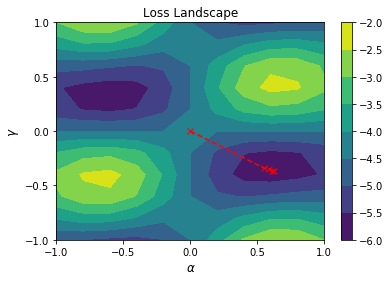

In [32]:
# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.]+[res[i].numpy()[0,0] for i in range(len(res[:-1]))]
params_y = [0.]+[res[i].numpy()[0,1] for i in range(len(res[:-1]))]

# Plot steps
plt.plot(params_x, params_y, linestyle = "--", color = "red", marker = "x")

plt.yticks(np.linspace(-1,1,5))
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r"$\alpha$", fontsize = 12)
plt.ylabel(r"$\gamma$", fontsize = 12)
plt.title("Loss Landscape", fontsize = 12)
plt.show()

--- 

### Generalization performances

A very interesting feature of this model, is that it can be straightforwardly applied to graphs having different number of nodes. In fact, until now our analysis focused to graphs having all the same number of nodes, but this was only for ease of explanation, but there is no restriction in this respect.  

Thus, we might want to challange our model to learn a good initialization heuristic for a generic graph, with an generic number of nodes. For this purpose, let's create a training dataset containing graphs having different number of nodes in the interval $n \in [7,9]$.

In [33]:
cell2 = tf.keras.layers.LSTMCell(2*n_layers)

g7 = generate_graphs(5, 7, 3/7)
g8 = generate_graphs(5, 8, 3/7)
g9 = generate_graphs(5, 9, 3/7)

gs = g7+g8+g9
gs_cost_list = [qaoa_from_graph(g) for g in gs]

import random
gs_cost_list = random.shuffle(gs_cost_list)

In [27]:
# Select an optimized 
opt = tf.keras.optimizers.Adam(learning_rate=0.1)

# Set the number of training epochs
epochs = 3

for epoch in range(epochs):
    print(f"Epoch {epoch}")
    total_loss = np.array([])
    for i, graph_cost in enumerate(gs_cost_list):
        loss = train_step(graph_cost)
        total_loss = np.append(total_loss, loss.numpy())
        # Log every 5 batches.
        if i % 5 == 0:
            print(f" > Graph {i}/{len(gs_cost_list)} - Loss: {loss}")
    print(f" >> Mean Loss: {np.mean(total_loss)}")

Epoch 0
 > Graph 0/100 - Loss: [[-1.2435602]]
 > Graph 5/100 - Loss: [[-1.5571034]]
 > Graph 10/100 - Loss: [[-1.7631152]]
 > Graph 15/100 - Loss: [[-2.7989807]]
 > Graph 20/100 - Loss: [[-2.9342427]]
 > Graph 25/100 - Loss: [[-3.8080506]]
 > Mean Loss: -2.254596296946208
Epoch 1
 > Graph 0/100 - Loss: [[-1.2460806]]
 > Graph 5/100 - Loss: [[-1.5977465]]
 > Graph 10/100 - Loss: [[-1.7737831]]
 > Graph 15/100 - Loss: [[-2.8268166]]
 > Graph 20/100 - Loss: [[-3.0138817]]
 > Graph 25/100 - Loss: [[-3.9591355]]
 > Mean Loss: -2.2909550110499066
Epoch 2
 > Graph 0/100 - Loss: [[-1.2468221]]
 > Graph 5/100 - Loss: [[-1.5990384]]
 > Graph 10/100 - Loss: [[-1.7777874]]
 > Graph 15/100 - Loss: [[-2.8236213]]
 > Graph 20/100 - Loss: [[-2.9467366]]
 > Graph 25/100 - Loss: [[-3.8228824]]
 > Mean Loss: -2.2735650221506756


These are optimized parameters for the LSTM cell:

In [28]:
optimized_weights = cell.get_weights()
print("Optimizer LSTM weights:\n")
optimized_weights

# To set initial weights for the cell, use:
# cell.set_weights(optimized_weights)

Optimizer LSTM weights:



[array([[-1.4990977 , -1.6186686 , -1.6079012 , -1.4279009 , -1.7163923 ,
          1.2226918 ,  0.2775383 ,  0.12405934],
        [ 0.8265473 ,  0.9897082 ,  0.79212624,  1.4582858 ,  0.36939698,
         -0.96255964, -0.69242704,  0.42092663],
        [-1.8966941 , -1.338229  , -0.84331644, -1.5420448 , -0.55026186,
          1.105887  , -0.6040543 ,  1.642047  ]], dtype=float32),
 array([[ 1.2750679 ,  1.5973562 ,  0.81222117,  0.9559596 ,  0.688454  ,
         -1.8477833 , -1.037921  , -0.4739683 ],
        [-1.5113798 , -1.434592  , -0.72621715, -1.043291  , -1.3425262 ,
          1.0954412 , -0.70966566,  1.696478  ]], dtype=float32),
 array([ 0.70145464, -0.15719399,  2.1610892 ,  2.1626966 ,  1.8296447 ,
        -1.6452899 ,  2.3302908 ,  1.171778  ], dtype=float32)]

# Performances

Let's check if this hybrid model eventually learnt a good heuristic to propose new updates for the parameters in the QAOA ansatz of the Maxcut problem.  
  

For this reason, we consider a new graph. In particular, we can take a graph with 10 nodes, which is something that the recurrent network has never seen before.

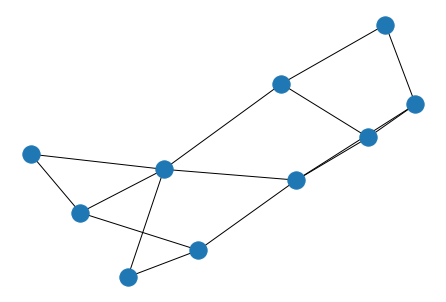

In [29]:
new_graph = nx.gnp_random_graph(10, p = 3/10)
new_cost = qaoa_from_graph(new_graph)

nx.draw(new_graph)

We call the trained recurrent LSTM on this graph, saving all intermediate guesses for the parameters, not only the last one. 

In [30]:
res = recurrent_loop(new_cost, intermediate_steps = True)

guess_0 = tf.zeros(shape = (2*n_layers, 1))
guess_1 = res[0]
guess_2 = res[1]
guess_3 = res[2]
guess_4 = res[3]
final_loss = res[4]

guesses = [guess_0, guess_1, guess_2, guess_3, guess_4]

# Losses from the hybrid LSTM model
lstm_losses = [new_cost(tf.reshape(guess, shape = (2, n_layers))) for guess in guesses]

### Confrontation with usual gradient descent strategy

In [31]:
x0 = tf.Variable(np.random.rand(2,1))

opt = tf.keras.optimizers.SGD(learning_rate=0.01)
step = 15

steps = []
sdg_losses = []
for _ in range(step):
    with tf.GradientTape() as tape:
        loss = new_cost(x0)
        
    steps.append(x0)
    sdg_losses.append(loss)
    
    gradients = tape.gradient(loss, [x0])
    opt.apply_gradients(zip(gradients, [x0]))
    print(f"Step {_} - Loss = {loss}")
    
print(f"Final cost function: {new_cost(x).numpy()}\nOptimized angles: {x.numpy()}")

Step 0 - Loss = [-7.15702164]
Step 1 - Loss = [-7.77113772]
Step 2 - Loss = [-8.31715217]
Step 3 - Loss = [-8.75791054]
Step 4 - Loss = [-9.0865965]
Step 5 - Loss = [-9.31944272]
Step 6 - Loss = [-9.4824355]
Step 7 - Loss = [-9.59952742]
Step 8 - Loss = [-9.68744988]
Step 9 - Loss = [-9.75609336]
Step 10 - Loss = [-9.81088848]
Step 11 - Loss = [-9.85491868]
Step 12 - Loss = [-9.89018614]
Step 13 - Loss = [-9.91821331]
Step 14 - Loss = [-9.94027775]
Final cost function: [-9.90388333]
Optimized angles: [0.6104711]


## Loss plot

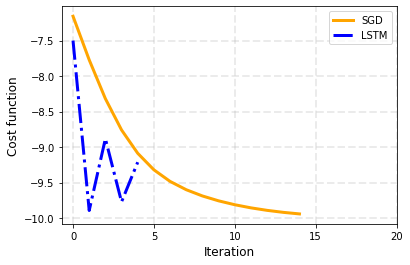

In [32]:
fig, ax = plt.subplots()

plt.plot(sdg_losses, color = "orange", lw = 3, label="SGD")

plt.plot(lstm_losses, color = "blue", lw = 3, ls = "-.", label="LSTM")

plt.grid(ls = "--", lw = 2, alpha = 0.25)
plt.legend()
plt.ylabel("Cost function", fontsize = 12)
plt.xlabel("Iteration", fontsize = 12)
ax.set_xticks([0,5,10,15,20]);

See that the custom optimizer based on the LSTM quickly reaches a good value of the loss function, much faster than  standard stochastic gradient descent.

## Loss landscape in parameter space

In [33]:
# Evaluate the cost function on a grid in parameter space
dx = dy = np.linspace(-1., 1., 11)
dz = np.array([new_cost([[xx],[yy]]).numpy() for yy in dy for xx in dx])
Z = dz.reshape((11,11))

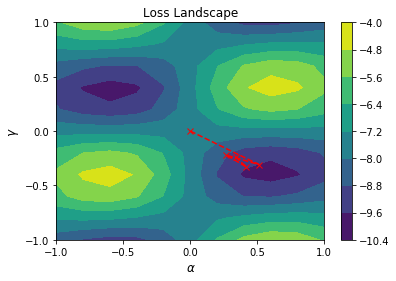

In [34]:
# Plot cost landscape
plt.contourf(dx, dy, Z)
plt.colorbar()

# Extract optimizer steps
params_x = [0.]+[res[i].numpy()[0,0] for i in range(len(res[:-1]))]
params_y = [0.]+[res[i].numpy()[0,1] for i in range(len(res[:-1]))]
# Plot steps
plt.plot(params_x, params_y, linestyle = "--", color = "red", marker = "x")

plt.yticks(np.linspace(-1,1,5))
plt.xticks(np.linspace(-1,1,5))
plt.xlabel(r"$\alpha$", fontsize = 12)
plt.ylabel(r"$\gamma$", fontsize = 12)
plt.title("Loss Landscape", fontsize = 12)
plt.show()